In [1]:
import requests
import pandas as pd

# URL of the file in the GitHub repository
url = "https://raw.githubusercontent.com/blueprints-for-text-analytics-python/blueprints-text/master/data/jdt-bugs-dataset/eclipse_jdt.csv.gz"

# Download the file
response = requests.get(url)
open("eclipse_jdt.csv.gz", "wb").write(response.content)

# Load the CSV file into a DataFrame
df = pd.read_csv("eclipse_jdt.csv.gz", compression='gzip')

# Display the first few rows
print(df.head())

# Display basic info about the DataFrame
print(df.info())


   Issue_id Priority Component  Duplicated_issue  \
0      1518       P1     Debug               NaN   
1      1519       P3     Debug               NaN   
2      1520       P3     Debug               NaN   
3      1521       P3     Debug               NaN   
4      1522       P2     Debug            1663.0   

                                               Title  \
0                 Icons needed for actions (1GI5UXW)   
1              README: Hit count not reset (1GET20Y)   
2               Use styled text in console (1G9S1YF)   
3              StringBuffer representation (1GE3BFA)   
4  Feature: use #toString to display variable val...   

                                         Description    Status  Resolution  \
0  JGS (8/8/01 5:20:19 PM); \tWe need enabled; di...  VERIFIED       FIXED   
1  JGS (6/4/01 11:43:47 AM); \tSet a breakpoint i...  RESOLVED  WORKSFORME   
2  DW (2/26/01 5:56:36 PM); \tCould allow users t...    CLOSED     WONTFIX   
3  JGS (5/21/01 2:09:10 PM); \tTo be c

## df에 대한 정보

### issue_id: 버그를 추적하는데 사용되는 이슈의 기본 키
### Priority: p1(가장중요)에서 p5(가장 덜 중요)까지 버그의 다양한 심각도(범주형 필드)를 정의
### Component: 버그가 발생한 프로젝트의 특정 아키텍처를 나타낸다. U1, APT등이 될 수 있다.(범주형 필드)
### Title: 전체 텍스트 필드
### Description: 버그 재현 경로와 버그가 소프트웨어 사용에 미치는 영향을 자세히 기술.

In [2]:
print(df.columns)

Index(['Issue_id', 'Priority', 'Component', 'Duplicated_issue', 'Title',
       'Description', 'Status', 'Resolution', 'Version', 'Created_time',
       'Resolved_time'],
      dtype='object')


In [3]:
df[['Issue_id','Priority','Component','Title','Description']].sample(2)

,Issue_id,Priority,Component,Title,Description
37738,226535,P3,Core,Partially disable the usage of raw type warning,Build ID: M20071023-1652; ; Steps To Reproduce...
17161,51454,P3,Text,Java editor improvement,Hightlight portion of java code and move to ta...


In [4]:
df.sample(1).T

,22699
Issue_id,78597
Priority,P3
Component,Debug
Duplicated_issue,NaN
Title,Duplicate mnemonic on exception breakpoint pro...
Description,I200411111200; ; Duplicate mnemonic &R on exce...
Status,VERIFIED
Resolution,FIXED
Version,3.1
Created_time,2004-11-15 05:02:00 -0500


<Axes: xlabel='Priority'>

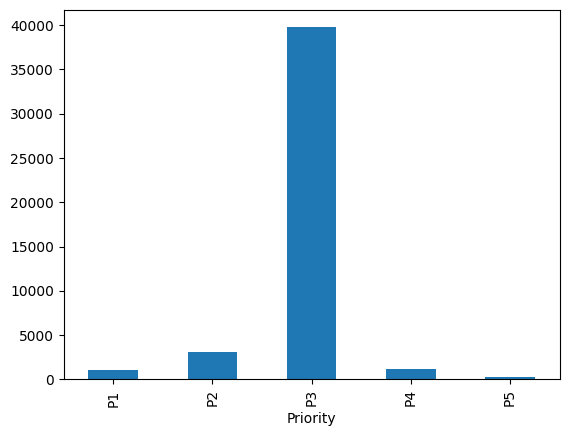

In [5]:
df['Priority'].value_counts().sort_index().plot(kind='bar')

In [6]:
df['Component'].value_counts()

,count
Component,
UI,17479
Core,13669
Debug,7542
Text,5901
APT,406
Doc,299


## 텍스트 분류 시스템 구축

  - 데이터 준비: 텍스트 분류 모델 구축을 진행하기 전에 데이터를 정리하고 머신러닝 알고리즘을 적용하기에 적합한 형태로 바꿈
  - 여기서 목표는 제목과 설명이 주어진 버그 보고서의 우선순위를 식별하는 것이므로 텍스트 분류 모델과 관련된 열만 선택한다. 그 후 특수문자를 제거한 후 텍스트 필드에 50자 미만인 관측 데이터를 필터링한다. 50자 미만의 버그 보고서는 올바르게 작성되지 않는다.

In [7]:
df = df[['Title','Description','Priority']]
df = df.dropna()
df['text'] = df['Title'] + ' ' + df['Description']
df = df.drop(columns=['Title','Description'])
df.columns

<ipython-input-7-b42059021ca4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['Title'] + ' ' + df['Description']


Index(['Priority', 'text'], dtype='object')

In [8]:
import re

def clean(text):
    # 텍스트 정리 로직 예시
    text = text.lower()  # 소문자로 변환
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # 특수 문자 제거
    text = re.sub(r'\s+', ' ', text).strip()  # 불필요한 공백 제거
    return text

df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]
df.sample(2, random_state=0)

,Priority,text
8517,P3,error ticks dont show up in types view 2002091...
23262,P4,internal error logged on edited stack trace i2...


# 훈련-테스트 분할
- 1. 100개의 데이텟에서 80:20 비율로 훈련-테스트 분할을 적용하면 80개 관측치가 훈련 분할이 되고 20개 관측치가 테스트 분할이 된다.

- 2. 80개 관측치를 가진 훈련 데이터로 학습된 함수가 제대로 학습됐는지 평가하기 위해 테스트 분할을 학습된 함수에 적용해 예측 결과를 얻는다.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])

print("Size of Training Data: ", X_train.shape[0])
print("Size of Test Data: ", X_test.shape[0])

Size of Training Data:  36055
Size of Test Data:  9014


## 머신러닝 모델 훈련
 - 이제는 적절한 알고리즘을 사용해 지도 머신러닝 모델을 훈련하는 것이다.
 - (X-Y 평면에 있는 각 점은 두 클래스 중 하나에 속한다. SVM은 두 클래스를 명확하게 구분하는 선이다.)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), stop_words="english")
X_train_df = tfidf.fit_transform(X_train)

In [11]:
from sklearn.svm import LinearSVC
model1= LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_df, Y_train)

LinearSVC(random_state=0, tol=1e-05)

## 모델 평가
  - 모델의 정확도를 수치화하는데 사용할 수 있는 메트릭
  정확도: 정확한 예측횟수/총예측횟수


In [12]:
from sklearn.metrics import accuracy_score
X_test_tf = tfidf.transform(X_test)

Y_pred = model1.predict(X_test_tf)
print("Accuracy Score - ", accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.8758597736853783


In [13]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_train_df, Y_train)
Y_pred_baseline = clf.predict(X_test_tf)
print("Accuracy score -:", accuracy_score(Y_test, Y_pred_baseline))

Accuracy score -: 0.8768582205458176


In [14]:
from sklearn.metrics import confusion_matrix
Y_pred = model1.predict(X_test_tf)
confusion_matrix(Y_test ,Y_pred)

array([[  26,    3,  191,    4,    0],
       [  12,   19,  570,    7,    0],
       [  18,   49, 7822,   15,    0],
       [   1,    3,  196,   28,    0],
       [   0,    0,   50,    0,    0]])

In [15]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

          P1       0.46      0.12      0.19       224
          P2       0.26      0.03      0.06       608
          P3       0.89      0.99      0.93      7904
          P4       0.52      0.12      0.20       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.88      9014
   macro avg       0.42      0.25      0.27      9014
weighted avg       0.82      0.88      0.83      9014



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 측정값 결과
  - 클래스 P3에 대한 재현율 및 정밀도 값은 상당히 높지만 그 외 클래스에 대해서는 낮고 어떤 경우(P5)에는 0이 되기까지 한다. 모델의 전체 정확도는 88%이지만, 예측결과를 항상 P3로 내놓도록 한다면 이때도 역시 정확도가 88%이다.
  이 점은 모델이 많은 의미를 학습하지 않고 단지 다수를 차지하는 클래스로 주로 예측

## 클래스 불균형 해결
  - 모델이 이러한 방식으로 동작하는 이유는 앞서 관찰한 우선순위 클래스의 클래스 불균형 때문이다. 우선순위가 P3인 버그가 3만 6천개에 가까운 반면, 그 외 우선순위 클래스의 버그수는 약 4천 개에 불과했으며 다른 경우에는 더 적었다. 즉 모델이 훈련할 때 P3클래스의 특성만 학습했을 가능성이 크다.

  - 불균형 문제 극복
  - 1. 업샘플링 기술: 소수 클래스의 관측치 수를 인위적으로 늘리는데 사용되며, 단순히 복사본을 여러 개 추가하는 거부터  SMOTE같은 방법을 사용해 새로운 샘플을 생성하는 것까지 다양할 수 있다.
  - 2. 다운샘플링 기술: 다수 클래스의 관측치 수를 인위적으로 줄이는데 사용되며, 다운샘플링을 수행하면 정보가 유실되므로 일반적으로는 좋은 생각이 아니다. 하지만 클래스 불균형 문제가 발생하면 모델이 올바른 정보를 학습하지 못하게 된다.
  - 3. SMOTE: 임의로 샘플을 선택한 후에 소수 클래스와 유사한 샘플들을 합성해 새로운 샘플을 생성(고려 중인 특성 벡터와 가장 가까운 이웃 벡터 사이의 차이를 가져온다. 이 차이에 0과 1사이의 난수를 곱하고 고려 중인 특성 벡터에 더한다. 이로 인해 두 개의 특성 샘플 사이의 선분을 따라 임의의 점이 선택된다.)

In [18]:
df['Priority'].value_counts().sort_values()

,count
Priority,
P5,252
P1,1117
P4,1140
P2,3040
P3,39520


In [19]:
# 우선순위가 P3인 버그 보고서를 필터링하고 4000개 행을 샘플링 한다.
df_sampleP3 = df[df['Priority'] == 'P3'].sample(n=4000)

# 다른 모든 버그 보고서를 포함하는 별도의 데이터프레임을 만든다.
df_sampleRest = df[df['Priority'] != 'P3']

# 두 개의 데이터프레임을 연결해 균형이 잡힌 새 버그 보고서 데이터셋을 만든다.
df_balanced = pd.concat([df_sampleRest, df_sampleP3])

In [20]:
df_balanced['Priority'].value_counts()

,count
Priority,
P3,4000
P2,3040
P4,1140
P1,1117
P5,252


# 텍스트 분류를 위한 최종 코드

In [23]:
df = df_balanced[['text','Priority']]
df = df.dropna()
# 데이터준비
df['text'] = df['text'].apply(clean)
# step2 - 훈련 테스트 분할
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])

print("Size of Training Data:", X_train.shape[0])
print("Size of Test Data:", X_test.shape[0])

# 머신러닝 훈련 모델
tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), stop_words='english')
X_train_df = tfidf.fit_transform(X_train)

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_df, Y_train)

# 모델 평가
X_test_tf = tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)
print("Accuracy Score:",accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data: 7639
Size of Test Data: 1910
Accuracy Score: 0.5005235602094241
              precision    recall  f1-score   support

          P1       0.43      0.30      0.35       224
          P2       0.43      0.48      0.45       608
          P3       0.57      0.64      0.60       800
          P4       0.49      0.37      0.42       228
          P5       0.25      0.02      0.04        50

    accuracy                           0.50      1910
   macro avg       0.43      0.36      0.37      1910
weighted avg       0.49      0.50      0.49      1910



In [24]:
clf = DummyClassifier(strategy="stratified")
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print("Accuracy score:",accuracy_score(Y_test, Y_pred_baseline))

Accuracy score: 0.2994764397905759


In [25]:
# Title과 Description을 결합한 데이터프레임을 생성하고,
# 탐색할 수 있는 실제 값과 예측 값
frame = {'text':X_test, 'actual':Y_test, 'predicted':Y_pred}
result = pd.DataFrame(frame)
result[((result['actual']=='P1') | (result['actual']=='P2')) & (result['actual']==result['predicted'])].sample(2)

,text,actual,predicted
7091,jrelib container on path results in xbootclass...,P2,P2
2229,ide crash performing hotcode replace on 14 bui...,P1,P1
